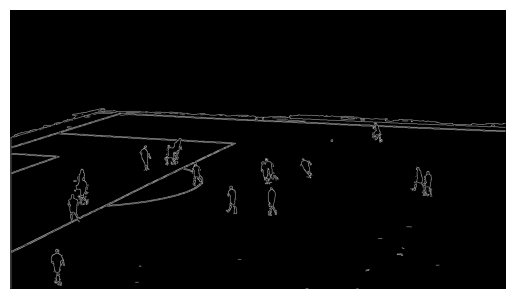

In [14]:
import matplotlib.pyplot as plt
from skimage import io, color, feature, transform
import numpy as np

# Load the image
image_path = "assets/green_region.png"
image = io.imread(image_path)
gray_image = color.rgb2gray(image)

# Perform edge detection using Canny
edges = feature.canny(gray_image, sigma=0.9)

#show the image
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.show()


In [20]:
# Perform Hough transform to detect lines
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
hspace, angles, distances = transform.hough_line(edges, theta=tested_angles)

# Extract line segments
lines = transform.hough_line_peaks(hspace, angles, distances, threshold=0.3 * np.max(hspace))


List of Intersection Coordinates (x, y):
(685.0643409010775, 288.2411427645953)
(2.869526767926484, 258.3728007693292)
(267.35090131274274, 269.95251375251934)
(1.2748943184436101, 622.8181373799478)
(1554.0151804049465, -136.93500144569427)
(2.4523234116517734, 353.7225584278572)


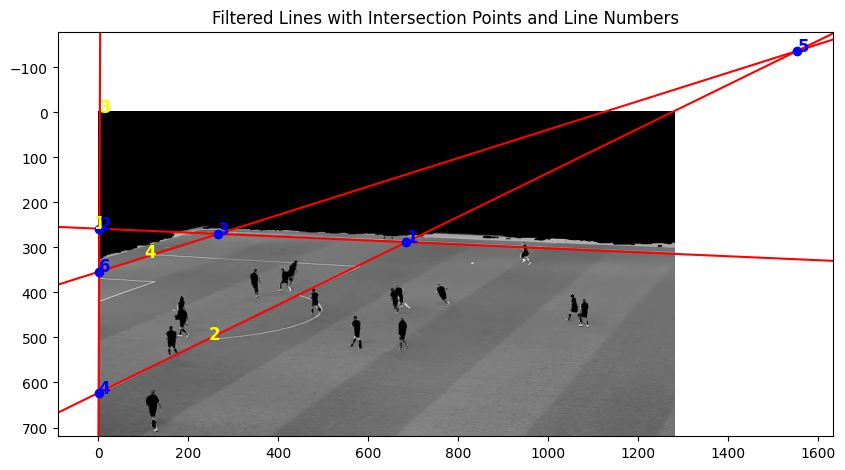

[(685.0643409010775, 288.2411427645953),
 (2.869526767926484, 258.3728007693292),
 (267.35090131274274, 269.95251375251934),
 (1.2748943184436101, 622.8181373799478),
 (1554.0151804049465, -136.93500144569427),
 (2.4523234116517734, 353.7225584278572)]

In [28]:
# Filter out small lines and very close parallel lines
filtered_lines = []
min_line_length = 100  # Minimum length of line to keep
min_distance_between_parallel_lines = 0  # Minimum distance between parallel lines

for _, angle, dist in zip(*lines): # Iterate over the lines
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle) # Calculate y-intercept
    y1 = (dist - gray_image.shape[1] * np.cos(angle)) / np.sin(angle) # Calculate y-intercept at the right edge of the image
    line_length = np.sqrt((gray_image.shape[1] - 0) ** 2 + (y1 - y0) ** 2)  # Calculate line length
    
    if line_length >= min_line_length:  # Filter out small lines
        too_close = False   
        for existing_angle, existing_dist in filtered_lines:    
            if (abs(existing_angle - angle) < 0.1 and abs(existing_dist - dist) < min_distance_between_parallel_lines): # Filter out very close parallel lines
                too_close = True
                break
        if not too_close:
            filtered_lines.append((angle, dist))

# Define a function to calculate the intersection of two lines
def calculate_intersection(line1, line2):
    """Calculate the intersection point of two lines given by (angle, distance) pairs."""
    angle1, dist1 = line1
    angle2, dist2 = line2

    # Lines in parametric form: r = x*cos(theta) + y*sin(theta)
    A = np.array([
        [np.cos(angle1), np.sin(angle1)],
        [np.cos(angle2), np.sin(angle2)]
    ])
    b = np.array([dist1, dist2])

    if np.linalg.det(A) == 0:  # Lines are parallel
        return None

    intersection_point = np.linalg.solve(A, b) # Solve for the intersection point
    return intersection_point

# Further filter out lines that are almost parallel to each other
angle_threshold = 0.1  # Angle threshold for determining parallel lines
filtered_lines_final = [] # List to store the final filtered lines

for angle, dist in filtered_lines:  # Iterate over the filtered lines
    too_close = False
    for existing_angle, existing_dist in filtered_lines_final:  # Iterate over the lines in filtered_lines_final
        if abs(existing_angle - angle) < angle_threshold:   # Filter out lines that are almost parallel
            too_close = True
            break
    if not too_close:   # If the line is not almost parallel to any other line in filtered_lines_final
        filtered_lines_final.append((angle, dist))  # Add the line to filtered_lines_final

# Find and print points of intersection of the remaining lines
intersection_points = []    # List to store the intersection points
for i in range(len(filtered_lines_final)):  # Iterate over the lines
    for j in range(i + 1, len(filtered_lines_final)):   # Iterate over the remaining lines
        point = calculate_intersection(filtered_lines_final[i], filtered_lines_final[j])    # Calculate the intersection point
        if point is not None:
            intersection_points.append(point)   # Add the intersection point to the list

# Filter out None values from intersection_points
intersection_points = [point for point in intersection_points if point is not None] 

# Store the intersection points as pairs of coordinates in a list
intersection_coordinates = [(point[0], point[1]) for point in intersection_points]  

# Print the list of intersection coordinates
print("List of Intersection Coordinates (x, y):")   
for coords in intersection_coordinates: 
    print(coords)   # Print the intersection coordinates

# Plot the remaining lines and their intersection points
fig, ax = plt.subplots(figsize=(10, 10))    
ax.imshow(gray_image, cmap=plt.cm.gray) # Display the image

for idx, (angle, dist) in enumerate(filtered_lines_final):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax.axline((x0, y0), slope=np.tan(angle + np.pi/2), color='r')
    ax.text(x0, y0, str(idx + 1), color='yellow', fontsize=12, weight='bold')  # Number the lines

for idx, point in enumerate(intersection_points):
    ax.plot(point[0], point[1], 'bo')  # Plot intersection points as blue dots
    ax.text(point[0], point[1], str(idx + 1), color='blue', fontsize=12, weight='bold')  # Number the points

ax.set_title('Filtered Lines with Intersection Points and Line Numbers')
plt.show()

# Return the list of intersection coordinates
intersection_coordinates

In [27]:
for idx, (angle, dist) in enumerate(filtered_lines_final):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax.axline((x0, y0), slope=np.tan(angle + np.pi/2), color='r')
    ax.text(x0, y0, str(idx + 1), color='yellow', fontsize=12, weight='bold')  # Number the lines

for idx, point in enumerate(intersection_points):
    ax.plot(point[0], point[1], 'bo')  # Plot intersection points as blue dots
    ax.text(point[0], point[1], str(idx + 1), color='blue', fontsize=12, weight='bold')  # Number the points

ax.set_title('Filtered Lines with Intersection Points and Line Numbers')
plt.show()

# Return the list of intersection coordinates
intersection_coordinates


[(685.0643409010775, 288.2411427645953),
 (2.869526767926484, 258.3728007693292),
 (267.35090131274274, 269.95251375251934),
 (1.2748943184436101, 622.8181373799478),
 (1554.0151804049465, -136.93500144569427),
 (2.4523234116517734, 353.7225584278572)]

List of Intersection Coordinates (x, y):


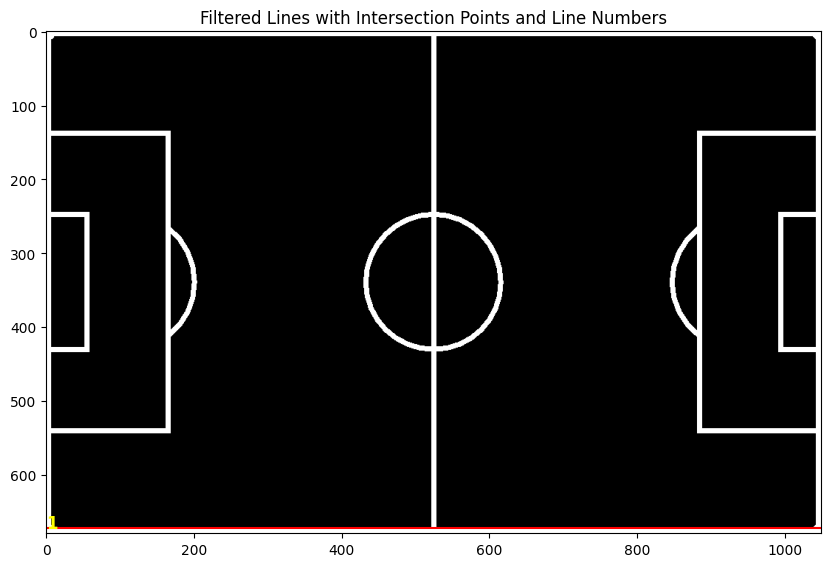

[]

In [2]:
import matplotlib.pyplot as plt
from skimage import io, color, feature, transform
import numpy as np

# Load the image
image_path = "assets\world_cup_template.png"
image = io.imread(image_path)
gray_image = color.rgb2gray(image)

# Perform edge detection using Canny
edges = feature.canny(gray_image, sigma=2.0)

# Perform Hough transform to detect lines
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
hspace, angles, distances = transform.hough_line(edges, theta=tested_angles)

# Extract line segments
lines = transform.hough_line_peaks(hspace, angles, distances, threshold=0.3 * np.max(hspace)) 

# Filter out small lines and very close parallel lines
filtered_lines = []
min_line_length = 100  # Minimum length of line to keep
min_distance_between_parallel_lines = 10  # Minimum distance between parallel lines

for _, angle, dist in zip(*lines):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - gray_image.shape[1] * np.cos(angle)) / np.sin(angle)
    line_length = np.sqrt((gray_image.shape[1] - 0) ** 2 + (y1 - y0) ** 2)
    
    if line_length >= min_line_length:
        too_close = False
        for existing_angle, existing_dist in filtered_lines:
            if (abs(existing_angle - angle) < 0.1 and abs(existing_dist - dist) < min_distance_between_parallel_lines):
                too_close = True
                break
        if not too_close:
            filtered_lines.append((angle, dist))

# Define a function to calculate the intersection of two lines
def calculate_intersection(line1, line2):
    """Calculate the intersection point of two lines given by (angle, distance) pairs."""
    angle1, dist1 = line1
    angle2, dist2 = line2

    # Lines in parametric form: r = x*cos(theta) + y*sin(theta)
    A = np.array([
        [np.cos(angle1), np.sin(angle1)],
        [np.cos(angle2), np.sin(angle2)]
    ])
    b = np.array([dist1, dist2])

    if np.linalg.det(A) == 0:  # Lines are parallel
        return None

    intersection_point = np.linalg.solve(A, b)
    return intersection_point

# Further filter out lines that are almost parallel to each other
angle_threshold = 0.1  # Angle threshold for determining parallel lines
filtered_lines_final = []

for angle, dist in filtered_lines:
    too_close = False
    for existing_angle, existing_dist in filtered_lines_final:
        if abs(existing_angle - angle) < angle_threshold:
            too_close = True
            break
    if not too_close:
        filtered_lines_final.append((angle, dist))

# Find and print points of intersection of the remaining lines
intersection_points = []
for i in range(len(filtered_lines_final)):
    for j in range(i + 1, len(filtered_lines_final)):
        point = calculate_intersection(filtered_lines_final[i], filtered_lines_final[j])
        if point is not None:
            intersection_points.append(point)

# Filter out None values from intersection_points
intersection_points = [point for point in intersection_points if point is not None]

# Store the intersection points as pairs of coordinates in a list
intersection_coordinates = [(point[0], point[1]) for point in intersection_points]

# Print the list of intersection coordinates
print("List of Intersection Coordinates (x, y):")
for coords in intersection_coordinates:
    print(coords)

# Plot the remaining lines and their intersection points
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(gray_image, cmap=plt.cm.gray)

for idx, (angle, dist) in enumerate(filtered_lines_final):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax.axline((x0, y0), slope=np.tan(angle + np.pi/2), color='r')
    ax.text(x0, y0, str(idx + 1), color='yellow', fontsize=12, weight='bold')  # Number the lines

for idx, point in enumerate(intersection_points):
    ax.plot(point[0], point[1], 'bo')  # Plot intersection points as blue dots
    ax.text(point[0], point[1], str(idx + 1), color='blue', fontsize=12, weight='bold')  # Number the points

ax.set_title('Filtered Lines with Intersection Points and Line Numbers')
plt.show()

# Return the list of intersection coordinates
intersection_coordinates


List of Intersection Coordinates (x, y) for new image:


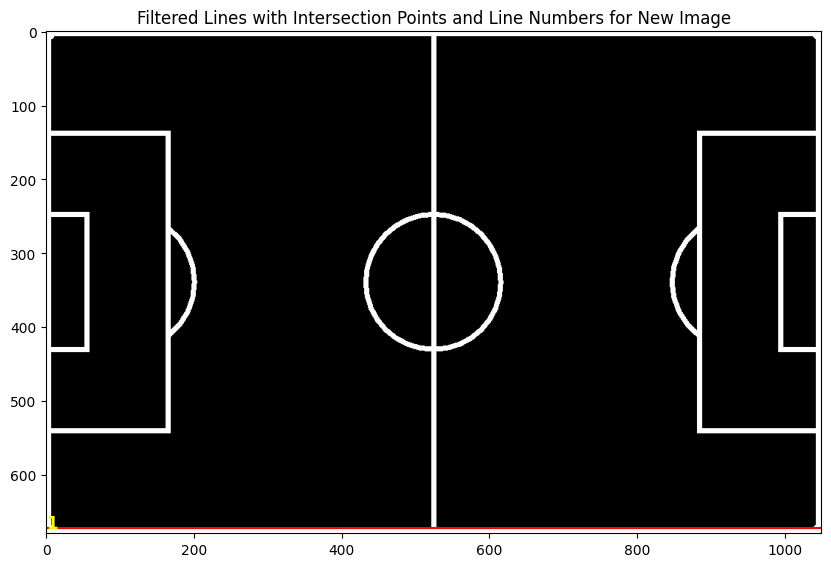

[]

In [3]:
import matplotlib.pyplot as plt
from skimage import io, color, feature, transform
import numpy as np

# Load the new image
new_image_path = "assets/world_cup_template.png"
new_image = io.imread(new_image_path)
gray_new_image = color.rgb2gray(new_image)

# Perform edge detection using Canny
edges_new = feature.canny(gray_new_image, sigma=2.0)

# Perform Hough transform to detect lines
hspace_new, angles_new, distances_new = transform.hough_line(edges_new, theta=tested_angles)

# Extract line segments
lines_new = transform.hough_line_peaks(hspace_new, angles_new, distances_new, threshold=0.3 * np.max(hspace_new))

# Filter out small lines and very close parallel lines
filtered_lines_new = []
for _, angle, dist in zip(*lines_new):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - gray_new_image.shape[1] * np.cos(angle)) / np.sin(angle)
    line_length = np.sqrt((gray_new_image.shape[1] - 0) ** 2 + (y1 - y0) ** 2)
    
    if line_length >= min_line_length:
        too_close = False
        for existing_angle, existing_dist in filtered_lines_new:
            if (abs(existing_angle - angle) < 0.1 and abs(existing_dist - dist) < min_distance_between_parallel_lines):
                too_close = True
                break
        if not too_close:
            filtered_lines_new.append((angle, dist))

# Further filter out lines that are almost parallel to each other
filtered_lines_final_new = []
for angle, dist in filtered_lines_new:
    too_close = False
    for existing_angle, existing_dist in filtered_lines_final_new:
        if abs(existing_angle - angle) < angle_threshold:
            too_close = True
            break
    if not too_close:
        filtered_lines_final_new.append((angle, dist))

# Find and print points of intersection of the remaining lines
intersection_points_new = []
for i in range(len(filtered_lines_final_new)):
    for j in range(i + 1, len(filtered_lines_final_new)):
        point = calculate_intersection(filtered_lines_final_new[i], filtered_lines_final_new[j])
        if point is not None:
            intersection_points_new.append(point)

# Filter out None values from intersection_points
intersection_points_new = [point for point in intersection_points_new if point is not None]

# Store the intersection points as pairs of coordinates in a list
intersection_coordinates_new = [(point[0], point[1]) for point in intersection_points_new]

# Print the list of intersection coordinates
print("List of Intersection Coordinates (x, y) for new image:")
for coords in intersection_coordinates_new:
    print(coords)

# Plot the remaining lines and their intersection points
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(gray_new_image, cmap=plt.cm.gray)

for idx, (angle, dist) in enumerate(filtered_lines_final_new):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax.axline((x0, y0), slope=np.tan(angle + np.pi/2), color='r')
    ax.text(x0, y0, str(idx + 1), color='yellow', fontsize=12, weight='bold')  # Number the lines

for idx, point in enumerate(intersection_points_new):
    ax.plot(point[0], point[1], 'bo')  # Plot intersection points as blue dots
    ax.text(point[0], point[1], str(idx + 1), color='blue', fontsize=12, weight='bold')  # Number the points

ax.set_title('Filtered Lines with Intersection Points and Line Numbers for New Image')
plt.show()

# Return the list of intersection coordinates
intersection_coordinates_new


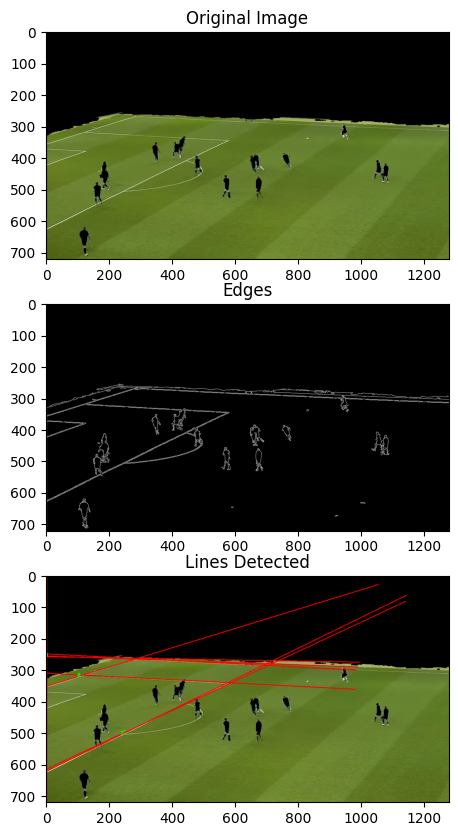

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# def filter_lines(lines, threshold):
#     if lines is None:
#         return []

#     filtered_lines = []
#     for i, line in enumerate(lines):
#         rho, theta = line[0]
#         close_to_existing = False
#         for existing_line in filtered_lines:
#             existing_rho, existing_theta = existing_line[0]
#             if abs(rho - existing_rho) < threshold and abs(theta - existing_theta) < np.pi / 180:
#                 close_to_existing = True
#                 break
#         if not close_to_existing:
#             filtered_lines.append(line)
#     return filtered_lines

def filter_lines(lines, threshold):
    if lines is None:
        return []

    filtered_lines = []
    for i, line in enumerate(lines):
        rho, theta = line[0]
        close_to_existing = False
        for existing_line in filtered_lines:
            existing_rho, existing_theta = existing_line[0]
            if abs(rho - existing_rho) < threshold and abs(theta - existing_theta) < np.pi / 180:
                close_to_existing = True
                break
        if not close_to_existing:
            filtered_lines.append(line)
    return filtered_lines

# Load the image
image_path = './assets/green_region.png'
image = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detector
edges = cv2.Canny(gray, 50, 150, apertureSize=3)

# Use Hough Line Transform to detect lines
lines = cv2.HoughLines(edges, 1, np.pi / 180, 170)

# print(lines)

# Filter lines to remove very close parallel lines
filtered_lines = filter_lines(lines, threshold=60)

# Create a copy of the original image to draw lines
line_image = np.copy(image)

# # Draw lines on the image in red color
# if lines is not None:
#     for line in filtered_lines:
#         rho, theta = line[0]
#         a = np.cos(theta)
#         b = np.sin(theta)
#         x0 = a * rho
#         y0 = b * rho
#         x1 = int(x0 + 1000 * (-b))
#         y1 = int(y0 + 1000 * (a))
#         x2 = int(x0 - 1000 * (-b))
#         y2 = int(y0 - 1000 * (a))
#         cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red color

# Draw lines on the image in red color and number them
for idx, line in enumerate(filtered_lines):
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(line_image, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red color
    # Calculate the midpoint of the line for numbering
    midpoint = (int((x1 + x2) / 2), int((y1 + y2) / 2))
    cv2.putText(line_image, str(idx+1), midpoint, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)  # Green color

# Display the original image, edges, and the image with lines
plt.figure(figsize=(15, 10))
plt.subplot(3,1, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(3,1, 2)
plt.title('Edges')
plt.imshow(edges, cmap='gray')

plt.subplot(3,1, 3)
plt.title('Lines Detected')
plt.imshow(cv2.cvtColor(line_image, cv2.COLOR_BGR2RGB))

plt.show()
